In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from prettytable import PrettyTable
from scipy.stats import chi2_contingency
from scipy.stats import shapiro, ttest_rel, wilcoxon, mannwhitneyu, ttest_ind
import wordcloud

In [2]:
df = pd.read_csv("Participant_logs/P1_experiment_logs.csv")
df['Uncertainties'] = df['Uncertainties'].apply(ast.literal_eval)

df.style.format({
}).set_properties(**{
    'text-align': 'center',
    'border': '1px solid black'
}).set_table_styles([
    dict(selector='th', props=[('text-align', 'center')]),
    dict(selector='th', props=[('background-color', '#f7f7f9')]),
    dict(selector='td', props=[('padding', '6px')])
])

,Participant Code,Condition,Task,Uncertainties,Selected Starting State,Selected State Uncertainty,Selected State Category,Uncertainty Categories
0,p1,blind,Phase1TaskLeft,"[5.858858906956926, 4.371270820246574, 4.44961857404317, 5.148377584658761, 4.571846943865117, 4.157613235105198, 3.4732849804833044, 2.5937287133970575, 2.3332533680260843, 2.387176048047101]",9,2.387176,Expected Failure,"['Highly Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Highly Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
1,p1,blind,Phase1TaskLeft,"[5.550994609899847, 4.257239349951271, 4.18302924112391, 5.078376426238713, 5.212879131126933, 5.9900745252682, 3.186260864646182, 2.5664827494506817, 2.3020022487064993, 2.0357252165391837]",8,2.302002,Expected Failure,"['Highly Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Unexpected Success', 'Highly Unexpected Success', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
2,p1,blind,Phase1TaskLeft,"[5.319908017717525, 4.701746194549301, 4.284823535542397, 4.712970146628436, 4.989524172827038, 6.628622307047623, 2.8579502514185506, 2.2781320845823583, 1.7711415393115622, 2.2319182740057752]",7,2.278132,Unexpected Failure,"['Highly Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Highly Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
3,p1,blind,Phase1TaskLeft,"[4.449368703398184, 4.3603530874126415, 4.292530309741646, 5.16751860173757, 6.060767330418458, 5.420509871268313, 3.217596116432788, 3.080502836499325, 2.8302572564079154, 2.7023582974175886]",8,2.830257,Expected Failure,"['Unexpected Failure', 'Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Highly Unexpected Failure', 'Highly Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
4,p1,blind,Phase1TaskLeft,"[4.484140905053232, 5.292951503666044, 5.073794101496313, 5.611141336137832, 6.138499616010063, 5.434685360533819, 3.772594168394454, 2.3950650856425626, 1.9917739661534246, 1.7039965879021353]",7,2.395065,Unexpected Failure,"['Unexpected Failure', 'Unexpected Success', 'Unexpected Success', 'Highly Unexpected Success', 'Highly Unexpected Failure', 'Unexpected Success', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
5,p1,visible,Phase1TaskLeft,"[5.378626661831089, 4.990856954598903, 4.451181298577448, 4.697146171579774, 5.047416178889375, 3.8413633665215645, 3.5827682834689565, 2.8343174034657688, 2.8005814053406257, 2.3127295429299517]",4,5.047416,Highly Unexpected Success,"['Highly Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Highly Unexpected Success', 'Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
6,p1,visible,Phase1TaskLeft,"[5.75622829264735, 4.577373043348945, 4.54653783967821, 5.828724851372043, 4.683454924942828, 6.197527477696029, 3.309425421140594, 2.178178680539742, 2.7874571349481636, 2.759554103851337]",5,6.197527,Highly Unexpected Success,"['Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Highly Unexpected Success', 'Unexpected Success', 'Highly Unexpected Success', 'Unexpected Failure', 'Expected Failure', 'Unexpected Failure', 'Expected Failure']"
7,p1,visible,Phase1TaskLeft,"[3.6840108230761355, 5.526475240186361, 4.667012111099342, 4.733915148490341, 5.12318317253394, 4.225106063330556, 3.4549498635604823, 2.728212211474585, 2.423971580303922, 1.4923693493744348]",4,5.123183,Highly Unexpected Failure,"['Unexpected Failure', 'Highly Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Highly Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'E

# DATA ANALYSIS

In [3]:

data_files = ['Participant_logs/P1_experiment_logs.csv', 'Participant_logs/P2_experiment_logs.csv', 'Participant_logs/P3_experiment_logs.csv', 'Participant_logs/P4_experiment_logs.csv', 'Participant_logs/P5_experiment_logs.csv', 'Participant_logs/P6_experiment_logs.csv', 'Participant_logs/P7_experiment_logs.csv', 'Participant_logs/P8_experiment_logs.csv', 'Participant_logs/P9_experiment_logs.csv', 'Participant_logs/P10_experiment_logs.csv', 'Participant_logs/P11_experiment_logs.csv', 'Participant_logs/P12_experiment_logs.csv']

data_list = []
for file in data_files:
    df = pd.read_csv(file)
    data_list.append(df)


data = pd.concat(data_list, ignore_index=True)

data['Uncertainties'] = data['Uncertainties'].apply(ast.literal_eval)
data['Uncertainty Categories'] = data['Uncertainty Categories'].apply(ast.literal_eval)

data['Selected State Uncertainty'] = pd.to_numeric(data['Selected State Uncertainty'])


Mann-Whitney U test: U-statistic = 76.0, p-value = 0.8271190942320861


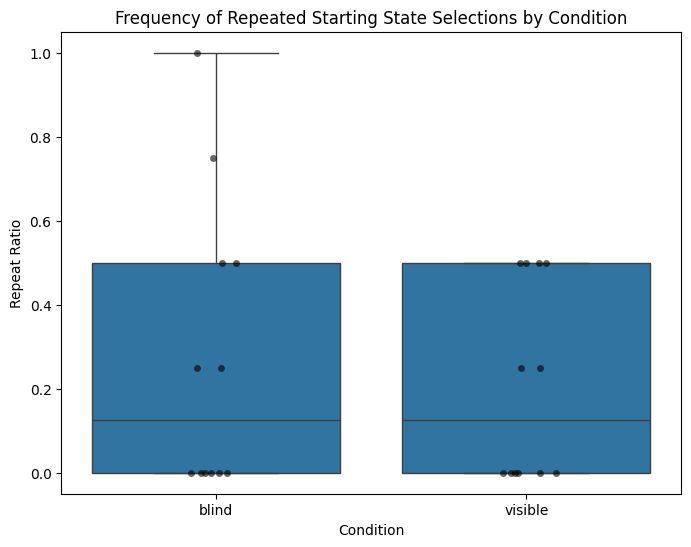

In [4]:
data['Trial'] = data.groupby(['Participant Code', 'Condition']).cumcount()

repeat_counts = []

participants = data['Participant Code'].unique()

for participant in participants:
    participant_data = data[data['Participant Code'] == participant]
    
    for condition in ['blind', 'visible']:
        condition_data = participant_data[participant_data['Condition'] == condition]
        
        condition_data = condition_data.sort_values(by='Trial').reset_index()
        
        repeated_selections = (condition_data['Selected Starting State'] == condition_data['Selected Starting State'].shift(1))
        repeat_count = repeated_selections.sum()  
        total_trials = len(condition_data) - 1  
        repeat_ratio = repeat_count / total_trials if total_trials > 0 else 0  
        
        repeat_counts.append({
            'Participant': participant,
            'Condition': condition,
            'Repeat Ratio': repeat_ratio
        })

repeat_df = pd.DataFrame(repeat_counts)

blind_repeats = repeat_df[repeat_df['Condition'] == 'blind']['Repeat Ratio']
visible_repeats = repeat_df[repeat_df['Condition'] == 'visible']['Repeat Ratio']

blind_normality = shapiro(blind_repeats)
visible_normality = shapiro(visible_repeats)

if blind_normality.pvalue > 0.05 and visible_normality.pvalue > 0.05:
    t_stat, t_pvalue = ttest_ind(blind_repeats, visible_repeats)
    print(f"Independent t-test: t-statistic = {t_stat}, p-value = {t_pvalue}")
else:
    u_stat, u_pvalue = mannwhitneyu(blind_repeats, visible_repeats)
    print(f"Mann-Whitney U test: U-statistic = {u_stat}, p-value = {u_pvalue}")


plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition', y='Repeat Ratio', data=repeat_df)
sns.stripplot(x='Condition', y='Repeat Ratio', data=repeat_df, color='black', alpha=0.6, jitter=True)
plt.title('Frequency of Repeated Starting State Selections by Condition')
plt.xlabel('Condition')
plt.ylabel('Repeat Ratio')
plt.show()

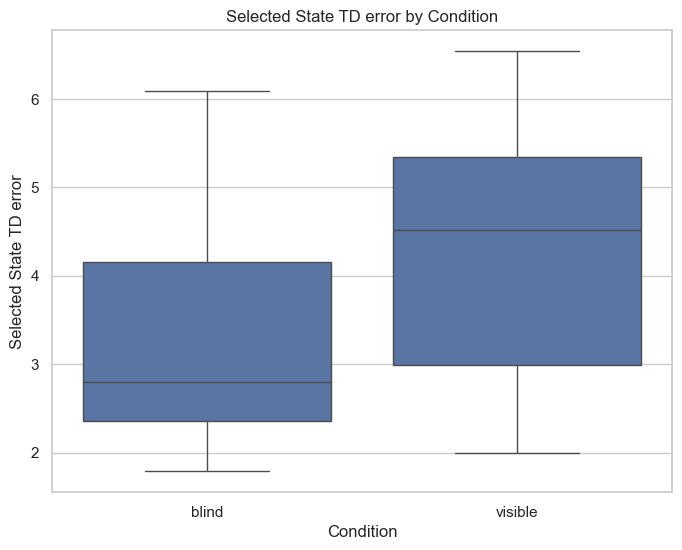

In [5]:
sns.set(style='whitegrid')

# Boxplot of Selected State Uncertainty by Condition
plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition', y='Selected State Uncertainty', data=data)
plt.title('Selected State TD error by Condition')
plt.xlabel('Condition')
plt.ylabel('Selected State TD error')
plt.show()

In [6]:
# TESTING TO SEE IF VISIBLE CONDITION SELECTED HIGHER TD ERROR VALUES:
blind_data = data[data['Condition'] == 'blind']['Selected State Uncertainty']
visible_data = data[data['Condition'] == 'visible']['Selected State Uncertainty']

shapiro_blind = shapiro(blind_data)
shapiro_visible = shapiro(visible_data)

print(f"Shapiro-Wilk test for blind condition: p-value = {shapiro_blind.pvalue}")
print(f"Shapiro-Wilk test for visible condition: p-value = {shapiro_visible.pvalue}")

if shapiro_blind.pvalue < 0.05 or shapiro_visible.pvalue < 0.05:
    stat, p_value = wilcoxon(blind_data, visible_data)
    print(f"Wilcoxon signed-rank test: p-value = {p_value}")
else:
    stat, p_value = ttest_rel(blind_data, visible_data)
    print(f"Paired t-test: p-value = {p_value}")


Shapiro-Wilk test for blind condition: p-value = 1.2619639524150617e-05
Shapiro-Wilk test for visible condition: p-value = 0.0017256049019908901
Wilcoxon signed-rank test: p-value = 0.0003465791905709803


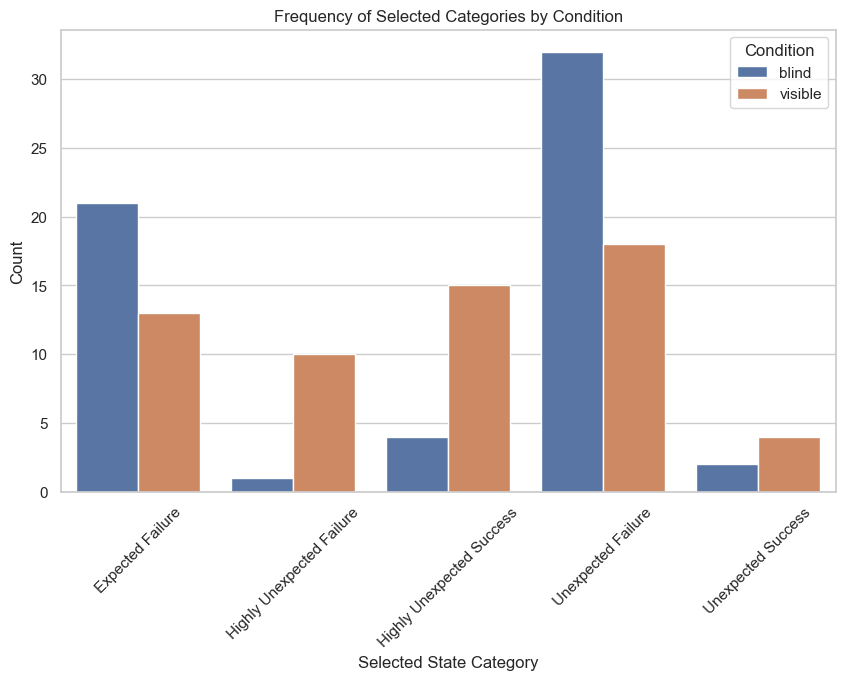

In [7]:
selected_categories = data[['Condition', 'Selected State Category']]

category_counts = selected_categories.groupby(['Condition', 'Selected State Category']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Selected State Category', y='Count', hue='Condition', data=category_counts)
plt.title('Frequency of Selected Categories by Condition')
plt.xlabel('Selected State Category')
plt.ylabel('Count')
plt.legend(title='Condition')
plt.xticks(rotation=45)
plt.show()

In [8]:
data['Highly Unexpected'] = data['Selected State Category'].isin(['Highly Unexpected Failure', 'Highly Unexpected Success'])
contingency_table = pd.crosstab(data['Condition'], data['Highly Unexpected'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic = {chi2_stat}")
print(f"p-value = {p_value}")
print(f"Degrees of freedom = {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic = 16.044444444444444
p-value = 6.187289775861156e-05
Degrees of freedom = 1
Expected frequencies:
[[45. 15.]
 [45. 15.]]


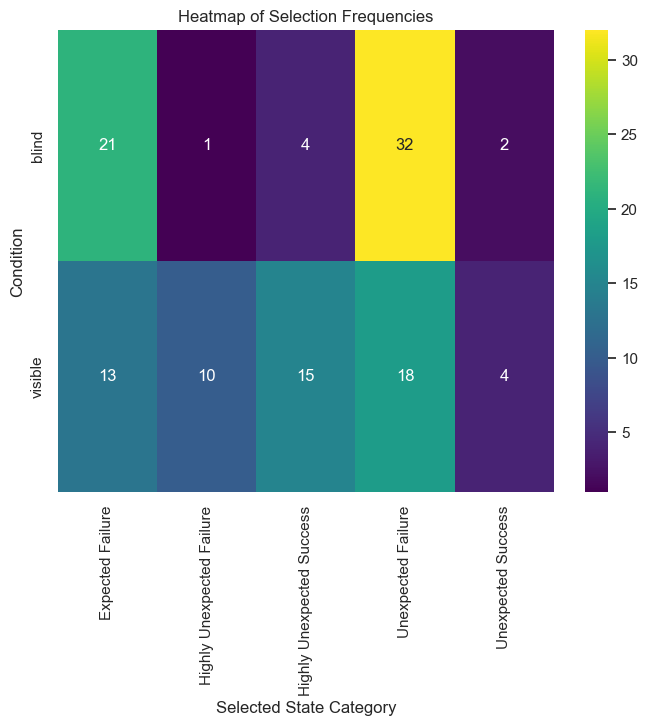

In [9]:
pivot_table = category_counts.pivot(index='Condition', columns='Selected State Category', values='Count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='g', cmap='viridis')
plt.title('Heatmap of Selection Frequencies')
plt.xlabel('Selected State Category')
plt.ylabel('Condition')
plt.show()

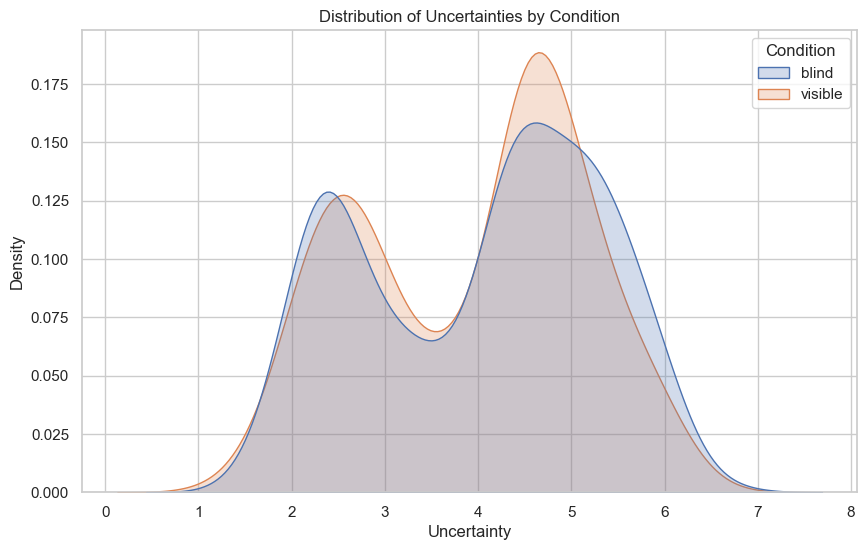

In [10]:
uncertainty_records = []

for idx, row in data.iterrows():
    uncertainties = row['Uncertainties']
    categories = row['Uncertainty Categories']
    for u, c in zip(uncertainties, categories):
        uncertainty_records.append({
            'Participant Code': row['Participant Code'],
            'Condition': row['Condition'],
            'Uncertainty': u,
            'Category': c
        })

uncertainty_df = pd.DataFrame(uncertainty_records)

plt.figure(figsize=(10, 6))
sns.kdeplot(x='Uncertainty', hue='Condition', data=uncertainty_df, fill=True)
plt.title('Distribution of Uncertainties by Condition')
plt.xlabel('Uncertainty')
plt.ylabel('Density')
plt.show()

In [11]:
selection_records = []

for idx, row in data.iterrows():
    uncertainties = row['Uncertainties']
    selected_state = row['Selected Starting State']
    for state_idx, uncertainty in enumerate(uncertainties):
        selection_records.append({
            'Participant Code': row['Participant Code'],
            'Condition': row['Condition'],
            'Trial': idx,
            'Starting State': state_idx,
            'Uncertainty': uncertainty,
            'Selected': 1 if state_idx == selected_state else 0
        })

selection_df = pd.DataFrame(selection_records)

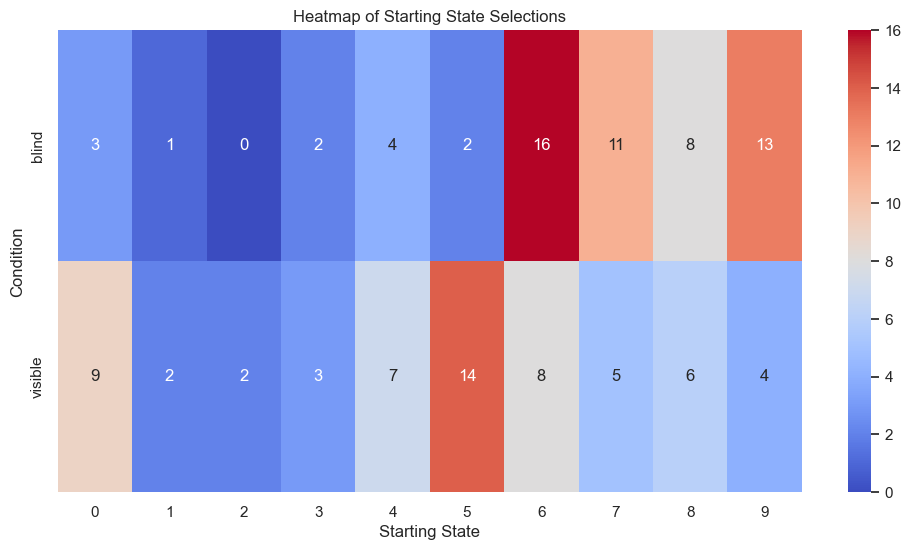

In [12]:
state_selection_counts = selection_df[selection_df['Selected'] == 1].groupby(['Condition', 'Starting State']).size().reset_index(name='Count')

state_pivot = state_selection_counts.pivot(index='Condition', columns='Starting State', values='Count').fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(state_pivot, annot=True, fmt='g', cmap='coolwarm')
plt.title('Heatmap of Starting State Selections')
plt.xlabel('Starting State')
plt.ylabel('Condition')
plt.show()

In [13]:
selection_records = []

for idx, row in data.iterrows():
    uncertainties = row['Uncertainties']
    selected_state = row['Selected Starting State']
    for state_idx, uncertainty in enumerate(uncertainties):
        selection_records.append({
            'Participant Code': row['Participant Code'],
            'Condition': row['Condition'],
            'Trial': idx,
            'Starting State': state_idx,
            'Uncertainty': uncertainty,
            'Selected': 1 if state_idx == selected_state else 0,
            'Selected Starting State': selected_state,  
            'Selected State Uncertainty': row['Selected State Uncertainty'], 
            'Selected State Category': row['Selected State Category'], 
        })

selection_df = pd.DataFrame(selection_records)

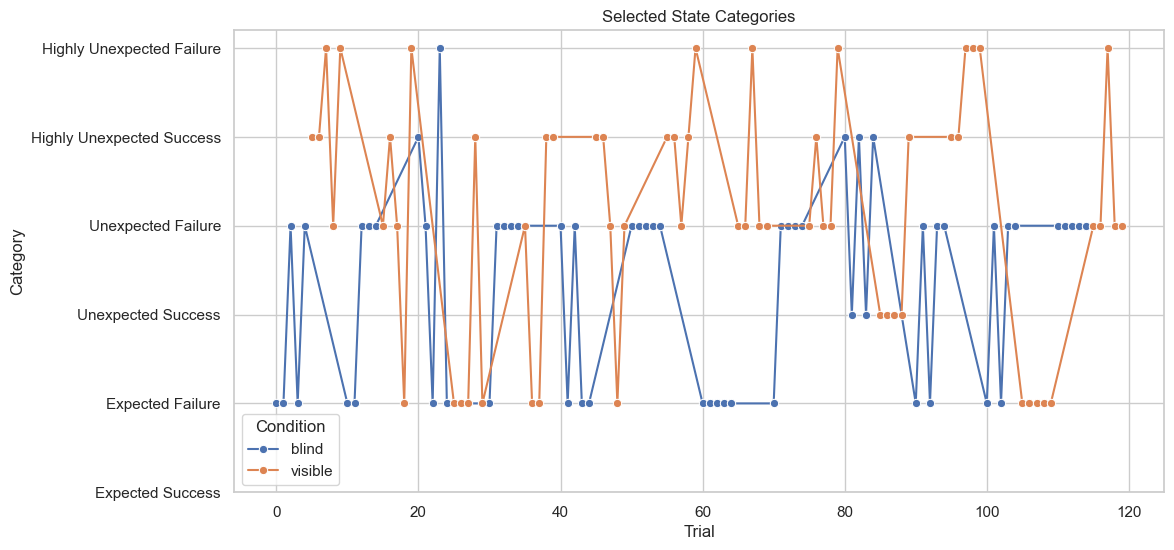

In [14]:
category_mapping = {'Highly Unexpected Success': 5, 'Highly Unexpected Failure': 6,
                    'Unexpected Success': 3, 'Unexpected Failure': 4,
                    'Expected Success': 1, 'Expected Failure': 2}

data['Selected Category Code'] = data['Selected State Category'].map(category_mapping)

plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y='Selected Category Code', hue='Condition', data=data, marker='o')
plt.title('Selected State Categories')
plt.xlabel('Trial')
plt.ylabel('Category')
plt.yticks([1, 2, 3, 4, 5, 6], ['Expected Success', 'Expected Failure', 'Unexpected Success', 'Unexpected Failure', 'Highly Unexpected Success', 'Highly Unexpected Failure'])
plt.legend(title='Condition')
plt.show()

# Merged data with logs and excel

In [15]:
experiment_logs_df = pd.concat(data_list, ignore_index=True)

experiment_logs_df['Uncertainties'] = experiment_logs_df['Uncertainties'].apply(ast.literal_eval)
experiment_logs_df['Uncertainty Categories'] = experiment_logs_df['Uncertainty Categories'].apply(ast.literal_eval)
experiment_logs_df['Selected State Uncertainty'] = pd.to_numeric(experiment_logs_df['Selected State Uncertainty'])

questionnaire_df = pd.read_excel('Participant_responses/Questionnaire (Responses).xlsx')
demographics_df = pd.read_excel('Participant_responses/Demographic information (Responses).xlsx')

merged_df = pd.merge(questionnaire_df, demographics_df, on='Your Subject ID', how='inner')

merged_full_df = pd.merge(experiment_logs_df, merged_df, left_on='Participant Code', right_on='Your Subject ID', how='inner')


# Looking and demographic and questionnaire specific information

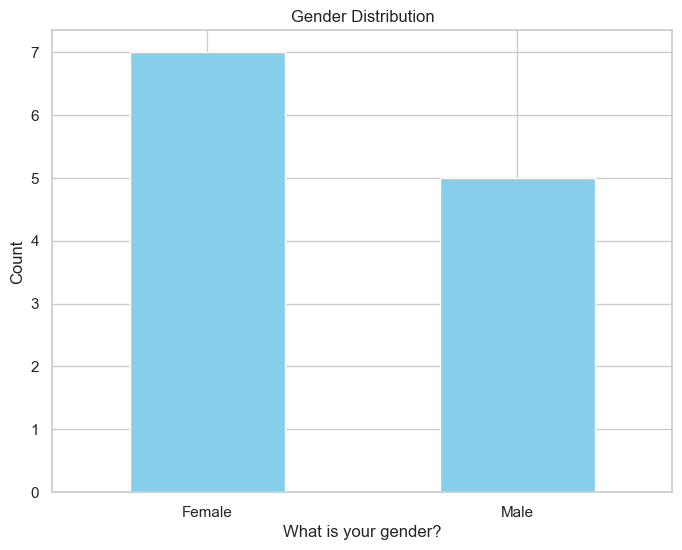

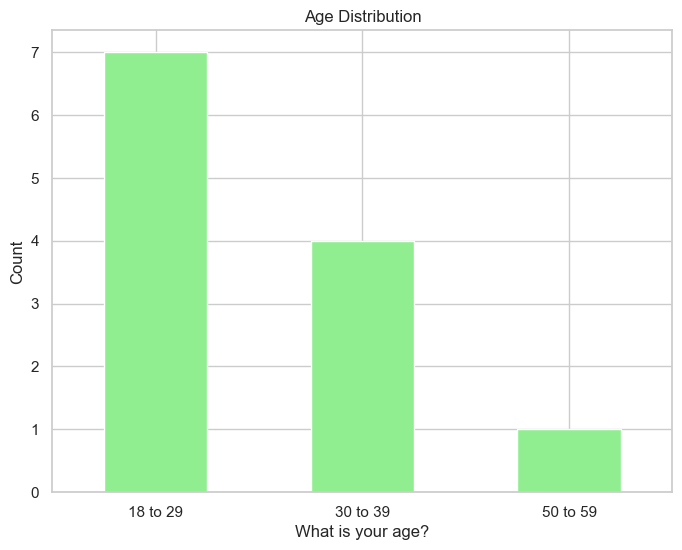

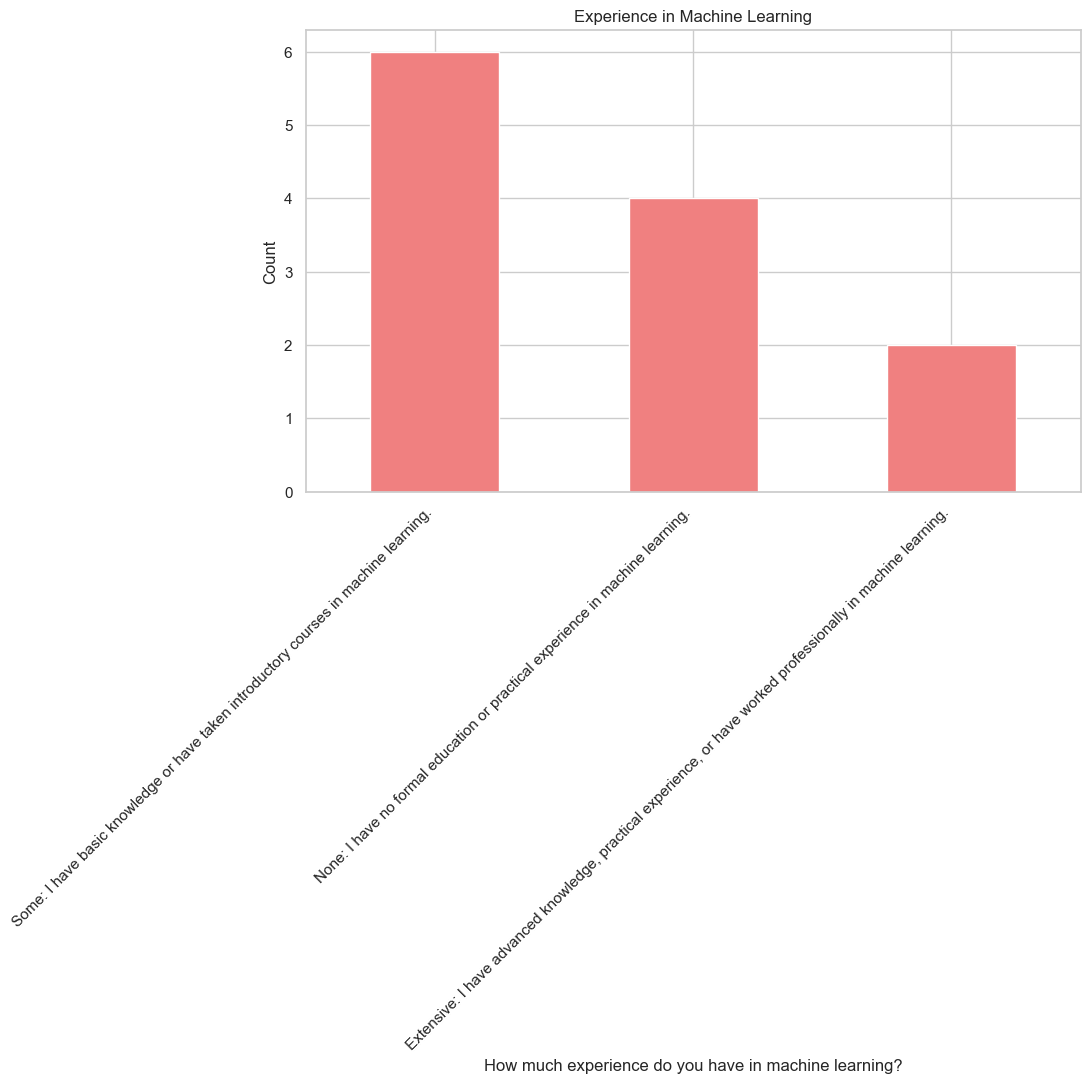

In [16]:
questionnaire_data = pd.read_excel('Participant_responses/Questionnaire (Responses).xlsx')
demographic_data = pd.read_excel('Participant_responses/Demographic information (Responses).xlsx')

demographic_data.columns = demographic_data.columns.str.strip()

gender_distribution = demographic_data['What is your gender?'].value_counts()
age_distribution = demographic_data['What is your age?'].value_counts()
experience_distribution = demographic_data['How much experience do you have in machine learning?'].value_counts()
color_blindness_distribution = demographic_data['Do you have any form of color blindness?'].value_counts()

gender_distribution, age_distribution, experience_distribution, color_blindness_distribution


plt.figure(figsize=(8, 6))
gender_distribution.plot(kind='bar', color='skyblue')
plt.title('Gender Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


plt.figure(figsize=(8, 6))
age_distribution.plot(kind='bar', color='lightgreen')
plt.title('Age Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


plt.figure(figsize=(10, 6))
experience_distribution.plot(kind='bar', color='lightcoral')
plt.title('Experience in Machine Learning')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()



# Analysing first and second open ended question (Strategy in part 1 and in part 2)

In [17]:
strat_blind_cond = pd.read_csv("Participant_responses/Strategy_Categorization_Blind_Condition.csv")
strat_blind_cond

,Response,Strategy
0,I wanted to select starting states where the r...,Failure-driven strategy
1,The states where the robot arm failed during t...,Failure-driven strategy
2,I chose starting positions near the red block ...,Difficulty-based strategy
3,choose the position I think is the most diffic...,Failure-driven strategy
4,1. by the state that failed the most surprisig...,Failure-driven strategy
5,I considered the starting states where the rob...,Failure-driven strategy
6,"At first, I chose a random failure and decided...",Failure-driven strategy/Consistency-focused st...
7,I kept repeating what the robot seemed to be d...,Failure-driven strategy/Consistency-focused st...
8,Seeing the robot arm successfully provide me w...,Unclear
9,I focused mainly on giving the algorithm infor...,Failure-driven strategy


In [18]:
strat_visible_cond = pd.read_csv("Participant_responses/Strategy_Categorization_Visible_Condition.csv")
strat_visible_cond

,Response,Strategy
0,I guess I looked at them more carefully. There...,Expectation-oriented strategy (Highly unexpected)
1,"I was thinking with my demonstrations, it coul...",Unclear
2,I decided to pick starting positions at the ex...,Expectation-oriented strategy (Highly unexpected)
3,prefer to choose the highly unexpected failure...,Expectation-oriented strategy (Highly unexpected)
4,basically by the delta between my robot surpri...,Expectation-oriented strategy (Highly unexpected)
5,"I think ""highly unexpected"" is like a big surp...",Expectation-oriented strategy (Highly unexpected)
6,This time I knew my demonstrations also affect...,Expectation-oriented strategy (Highly unexpected)
7,"didn't influence much, i continued same strate...",Consistency-focused strategy (Highly unexpected)
8,Only a little as I would have pre-empted that ...,Unclear
9,I focused on the positions where it had the bi...,Expectation-oriented strategy (Highly unexpected)
